# Inference Analysis

In this notebook we're looking at the statistical significance of distribution differences between audio features of hits versus non-hits. This is not testing all features, only those that seemed relevant for the model built in the EDA notebook.

In [8]:
import pandas as pd

# Import Data
train = pd.read_csv('../data/processed/train.csv',sep='\t',parse_dates=['date','entry_date','exit_date','peak_date','max_leap_date']).set_index(['artist','title'])

hits = train.loc[train.hit == True,:].copy()
nhits = train.loc[train.hit == False,:].copy()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Seed Random
np.random.seed(500)

def bins_rule_of_thumb(data):
    return int(np.sqrt(len(data)))

# Define Comparison Function Difference of Means
def mean_diff(data1,data2):
    mean1 = np.mean(data1)
    mean2 = np.mean(data2)
    return mean1 - mean2

# Create Permutation Sample Function
def permutation_sample(data1,data2):
    """
    Creates a Permutation Sample from two data sets and returns two permutated samples 
    with the same length as the original sets.
    """
    data_both = np.concatenate((data1,data2))
    data_perm = np.random.permutation(data_both)
    perm_sample_1 = data_perm[:len(data1)]
    perm_sample_2 = data_perm[len(data1):]
    return (perm_sample_1,perm_sample_2)

# Define function to generate Permutation Replicates
def draw_perm_reps(data1,data2,func,size=1):
    perm_replicates = np.empty(size)
    for i in range(size):
        perm_sample_1,perm_sample_2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_sample_1,perm_sample_2)
        
    return perm_replicates

def ecdf(data):
    """
    Returns the x,y values for data for plotting as an ecdf.
    """
    # Sort the data along the x-axis
    x = np.sort(data)
    
    # Index the data at equidistant intervals
    y = np.arange(1, len(x) + 1) / len(x)
    
    return x,y

def test_mean_diff(data1,data2,mean_diff_val,h0_diff=0):
    perm_replicates = draw_perm_reps(data1,data2,mean_diff,10000)

    if mean_diff_val > 0:
        p = np.sum(perm_replicates >= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))
    else:
        p = np.sum(perm_replicates <= mean_diff_val) / len(perm_replicates)
        print("p: {}".format(p))

    CI = np.percentile(perm_replicates,[2.5,97.5])
    print("CI: {}".format(CI))

    ME = CI[1] - np.mean(perm_replicates)
    print("ME: {}".format(ME))

    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,5))

    plt.subplot(1,2,1)

    dist_ax = sns.distplot(perm_replicates,bins=25,color='gray')
    max_dist_y = np.array([h.get_height() for h in dist_ax.patches]).max()
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Density')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='upper left')
    _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,max_dist_y*0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})


    ## CI_area = perm_replicates[perm_replicates <= CI[0]]
    ## _ = plt.hist(CI_area)

    plt.subplot(1,2,2)

    x,y = ecdf(perm_replicates)
    y_interp = np.interp(x,x,y)
    _ = plt.plot(x,y_interp,color='gray')
    if mean_diff_val >= 0:
        _ = plt.xlim(-mean_diff_val - 0.005,mean_diff_val + 0.005)
    else:
        _ = plt.xlim(mean_diff_val - 0.005,-mean_diff_val + 0.005)
    _ = plt.xlabel('Mean Difference of {}'.format(data1.name))
    _ = plt.ylabel('Cumulative Probability')
    _ = plt.legend(['Mean Difference Distribution \nfor p(hits)=p(nhits)'],loc='lower right')
    if mean_diff_val >= 0:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,1),xytext=(mean_diff_val,0.8),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})
    else:
        _ = plt.annotate(s='Point Estimate',xy=(mean_diff_val,0),xytext=(mean_diff_val,0.2),
                     arrowprops={'width':1.5,'headwidth':5,'color': 'red'})

To better understand whether the distributions are statistically significantly different we'll use a Z-Test.

    H0: The Danceability Distribution for Hits and Non-Hits is the same (i.e. the mean diff is 0).
    H1: The Danceability Distribution for Hits and Non-Hits is not the same.
    alpha = 0.05

Hits Mean: 0.5957135504885993
Non-Hits Mean: 0.5295059136044526
Mean Diff: 0.06620763688414666
H0 Diff: 0
p: 0.0
CI: [-0.00370526  0.00370288]
ME: 0.0037056383867070703


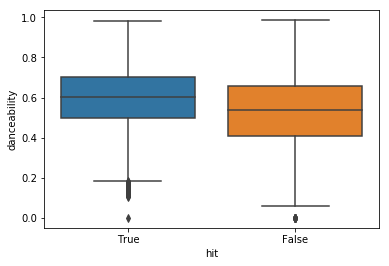

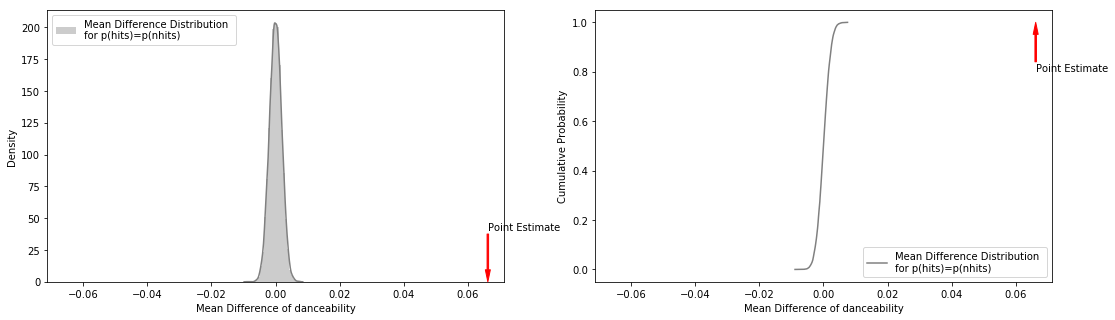

In [18]:
hits_danceability = hits.danceability.dropna()
nhits_danceability = nhits.danceability.dropna()

hits_nhits_diff = hits_danceability.mean() - nhits_danceability.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.danceability.mean(), nhits.danceability.mean(), hits_nhits_diff,h0_diff))

sns.boxplot(x='hit',y='danceability',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_danceability,nhits_danceability,hits_nhits_diff)

Hits Mean: 0.6176291400651467
Non-Hits Mean: 0.5279292037126051
Mean Diff: 0.08969993635254148
H0 Diff: 0
p: 0.0
CI: [-0.00528616  0.00529429]
ME: 0.005255728431750012


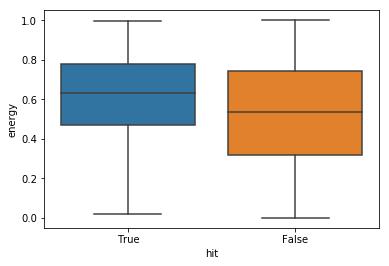

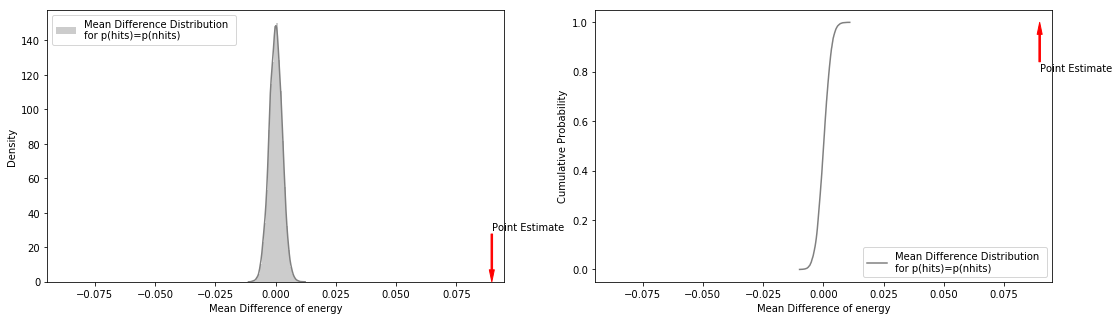

In [19]:
hits_energy = hits.energy.dropna()
nhits_energy = nhits.energy.dropna()

hits_nhits_diff = hits_energy.mean() - nhits_energy.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.energy.mean(), nhits.energy.mean(), hits_nhits_diff,h0_diff))

sns.boxplot(x='hit',y='energy',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_energy,nhits_energy,hits_nhits_diff)

Hits Mean: 0.2987878794723128
Non-Hits Mean: 0.43604737878122823
Mean Diff: -0.13725949930891557
H0 Diff: 0


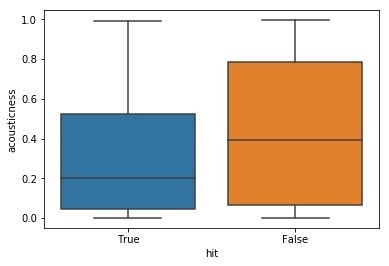

p: 0.0
CI: [-0.0074448   0.00734715]
ME: 0.007334273928491417


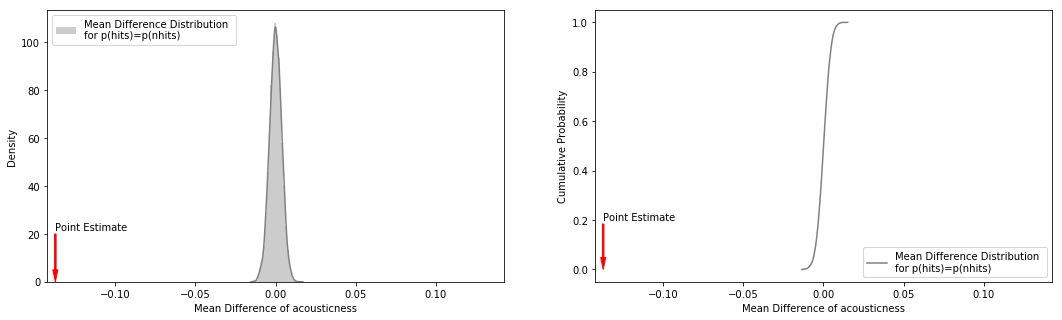

In [20]:
hits_acousticness = hits.acousticness.dropna()
nhits_acousticness = nhits.acousticness.dropna()

hits_nhits_diff = hits_acousticness.mean() - nhits_acousticness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.acousticness.mean(), nhits.acousticness.mean(), hits_nhits_diff,h0_diff))

sns.boxplot(x='hit',y='acousticness',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_acousticness,nhits_acousticness,hits_nhits_diff)

Hits Mean: -8.802725342019542
Non-Hits Mean: -11.022258743912465
Mean Diff: 2.219533401892921
H0 Diff: 0


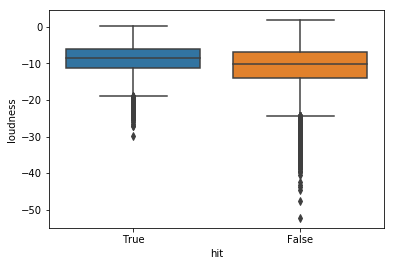

p: 0.0
CI: [-0.10864987  0.10763223]
ME: 0.10743461570403151


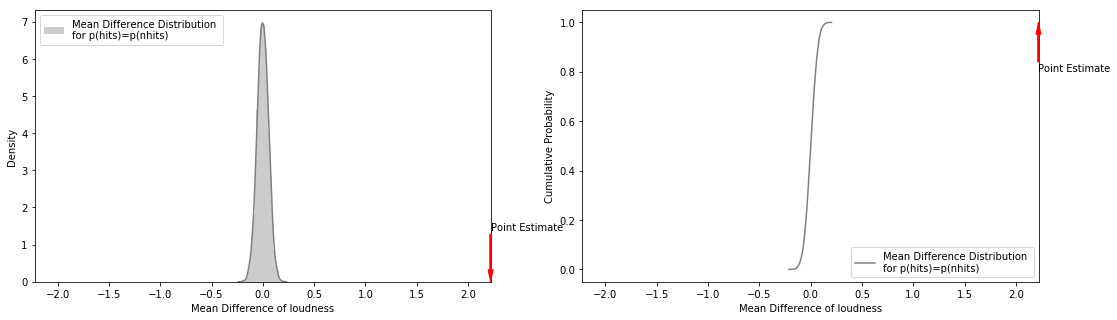

In [21]:
hits_loudness = hits.loudness.dropna()
nhits_loudness = nhits.loudness.dropna()

hits_nhits_diff = hits_loudness.mean() - nhits_loudness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.loudness.mean(), nhits.loudness.mean(), hits_nhits_diff,h0_diff))

_ = sns.boxplot(x='hit',y='loudness',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_loudness,nhits_loudness,hits_nhits_diff)

Hits Mean: 0.06883432573289902
Non-Hits Mean: 0.09073435582822086
Mean Diff: -0.02190003009532182
H0 Diff: 0


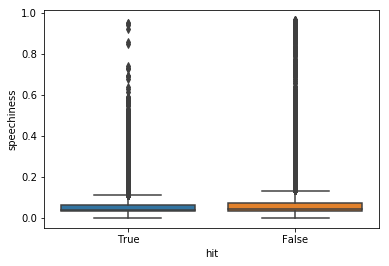

p: 0.0
CI: [-0.00256972  0.00259247]
ME: 0.002597472303504768


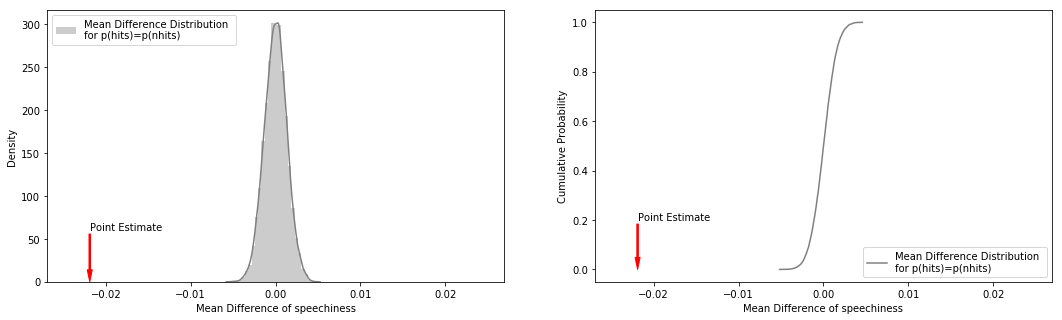

In [23]:
hits_speechiness = hits.speechiness.dropna()
nhits_speechiness = nhits.speechiness.dropna()

hits_nhits_diff = hits_speechiness.mean() - nhits_speechiness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.speechiness.mean(), nhits.speechiness.mean(), hits_nhits_diff,h0_diff))

_ = sns.boxplot(x='hit',y='speechiness',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_speechiness,nhits_speechiness,hits_nhits_diff)

Hits Mean: 0.6109236091205211
Non-Hits Mean: 0.5214109423818861
Mean Diff: 0.08951266673863512
H0 Diff: 0


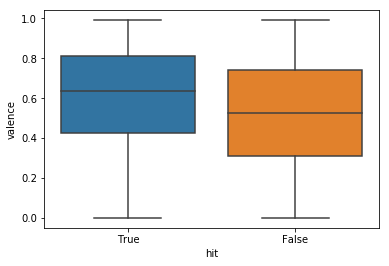

p: 0.0
CI: [-0.00573459  0.00549094]
ME: 0.005519182122970916


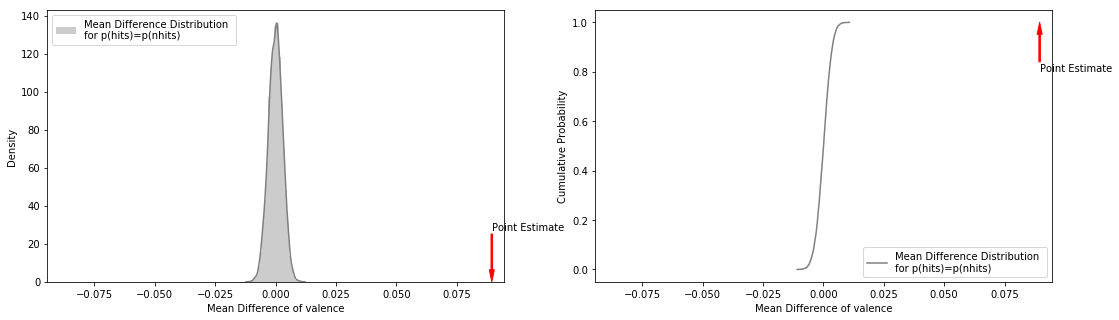

In [24]:
hits_valence = hits.valence.dropna()
nhits_valence = nhits.valence.dropna()

hits_nhits_diff = hits_valence.mean() - nhits_valence.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.valence.mean(), nhits.valence.mean(), hits_nhits_diff,h0_diff))

_ = sns.boxplot(x='hit',y='valence',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_valence,nhits_valence,hits_nhits_diff)

Hits Mean: 0.03421712542280131
Non-Hits Mean: 0.15391891948833092
Mean Diff: -0.11970179406552961
H0 Diff: 0


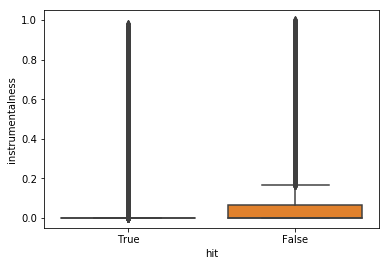

p: 0.0
CI: [-0.00538748  0.00539962]
ME: 0.005444008211340344


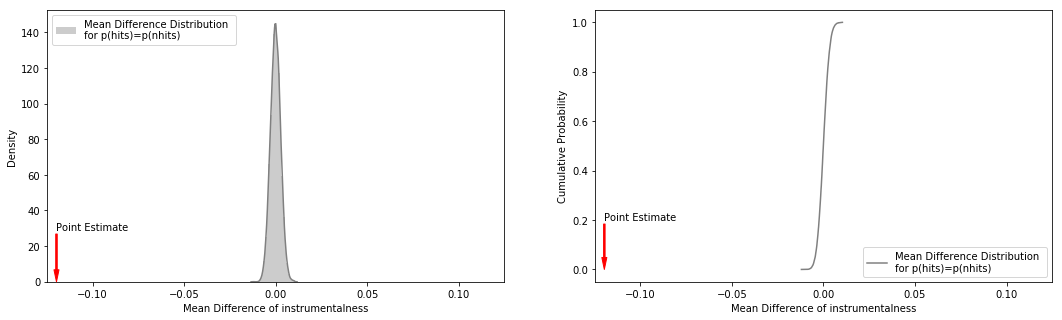

In [25]:
hits_instrumentalness = hits.instrumentalness.dropna()
nhits_instrumentalness = nhits.instrumentalness.dropna()

hits_nhits_diff = hits_instrumentalness.mean() - nhits_instrumentalness.mean()
h0_diff = 0
print("Hits Mean: {}\nNon-Hits Mean: {}\nMean Diff: {}\nH0 Diff: {}".format(hits.instrumentalness.mean(), nhits.instrumentalness.mean(), hits_nhits_diff,h0_diff))

_ = sns.boxplot(x='hit',y='instrumentalness',data=train,order=[True,False])
plt.show()

test_mean_diff(hits_instrumentalness,nhits_instrumentalness,hits_nhits_diff)